# 2. Low-pass filter

### Based on Lena/Baboon, and F16.raw

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [2]:
#匯入四個 raw檔
imgDatalena = np.fromfile('data/lena.raw', dtype='uint8')
imgDataBaboon = np.fromfile('data/Baboon.raw', dtype='uint8')
imgDataF16 = np.fromfile('data/F16.raw', dtype='uint8')
imgDataNoisy = np.fromfile('data/Noisy.raw', dtype='uint8')

In [3]:
def raw_read(imgData):
    nr = 512
    nc = 512
    nchan = 1
    c = 0 #用 c來記錄 raw檔讀取到的 index位置
    img = np.zeros((nr, nc, nchan))
    for i in range(nr):
        for j in range(nc):
            for k in range(0, nchan):
                img[i, j, k] = imgData[c]
                c=c+1
    return img

In [4]:
img_lena = raw_read(imgDatalena)
img_Baboon = raw_read(imgDataBaboon)
img_F16 = raw_read(imgDataF16)
img_Noisy = raw_read(imgDataNoisy)

### i. Make a Random Noise generator (uniform and Gaussian with specific mean/var) to add the noise to the original images in Spatial Domain.

In [5]:
def show_img(img):
    plt.figure(figsize=(10,10)) 
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.show()

In [6]:
def gaussian_noise(img, mean=0, sigma=0.1):  
    # int -> float (標準化)
    img = img / 255.0
    # 隨機生成高斯 noise (float + float)
    noise = np.random.normal(mean, sigma, img.shape)
    # noise + 原圖
    gaussian_out = img + noise
    # 所有值必須介於 0~1 之間，超過1 = 1，小於0 = 0
    gaussian_out = np.clip(gaussian_out, 0, 1)
    
    # 原圖: float -> int (0~1 -> 0~255)
    gaussian_out = np.uint8(gaussian_out*255)
    # noise: float -> int (0~1 -> 0~255)
    noise = np.uint8(noise*255)

    return gaussian_out

In [7]:
def uniform_noise(img):  
    # int -> float (標準化)
    img = img / 255.0
    # 隨機生成uniform noise (float + float)
    noise = np.random.uniform(0,1,img.shape)
    # noise + 原圖
    uniform_out = img + noise
    # 所有值必須介於 0~1 之間，超過1 = 1，小於0 = 0
    uniform_out = np.clip(uniform_out, 0, 1)
    
    # 原圖: float -> int (0~1 -> 0~255)
    uniform_out = np.uint8(uniform_out*255)
    # noise: float -> int (0~1 -> 0~255)
    noise = np.uint8(noise*255)

    return uniform_out

### uniform noise

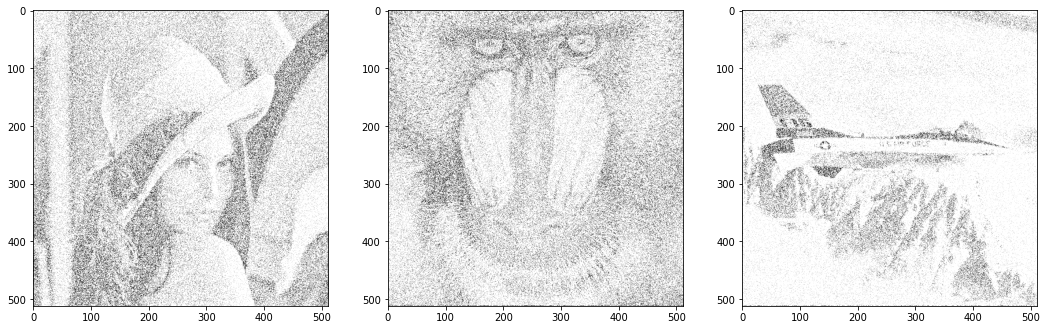

In [8]:
lena_uniform_noise = uniform_noise(img_lena.copy())
Baboon_uniform_noise = uniform_noise(img_Baboon.copy())
F16_uniform_noise = uniform_noise(img_F16.copy())

images = [lena_uniform_noise, Baboon_uniform_noise, F16_uniform_noise]
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 18))
for ind, p in enumerate(images):
    ax = axs[ind]
    ax.imshow(p, cmap='gray')
plt.show()

### Gaussian noise

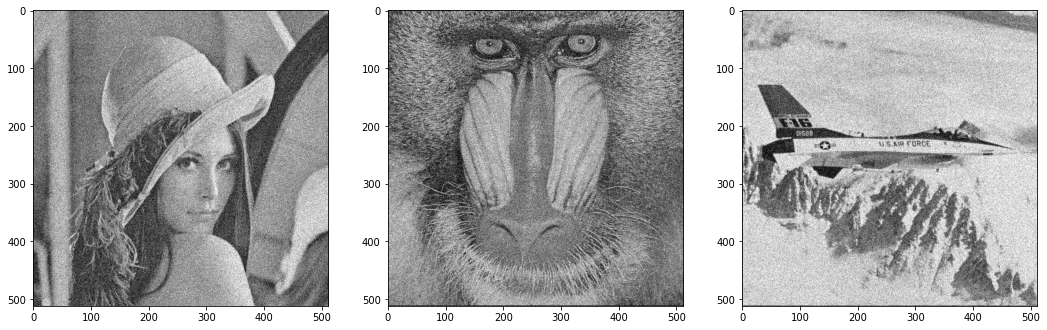

In [9]:
lena_gaussian_noise = gaussian_noise(img_lena.copy())
Baboon_gaussian_noise = gaussian_noise(img_Baboon.copy())
F16_gaussian_noise = gaussian_noise(img_F16.copy())

images = [lena_gaussian_noise, Baboon_gaussian_noise, F16_gaussian_noise]
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 18))
for ind, p in enumerate(images):
    ax = axs[ind]
    ax.imshow(p, cmap='gray')
plt.show()

### ii.  Apply the ideal low-pass filter to obtain the denoised results with different settings 

In [10]:
def post_process_image(image):
        """Post process the image to create a full contrast stretch of the image
        takes as input:
        image: the image obtained from the inverse fourier transform
        return an image with full contrast stretch
        -----------------------------------------------------
        1. Full contrast stretch (fsimage)
        2. take negative (255 - fsimage)
        """
        a = 0
        b = 255
        c = np.min(image)
        d = np.max(image)
        rows, columns = np.shape(image)
        image1 = np.zeros((rows, columns), dtype=int)
        for i in range(rows):
            for j in range(columns):
                if (d-c) == 0:
                    image1[i, j] = ((b - a) / 0.000001) * (image[i, j] - c) + a
                else:
                    image1[i, j] = ((b - a) / (d - c)) * (image[i, j] - c) + a

        return np.uint8(image1)

In [11]:
def filtering(img, mask):
    # Compute the fft of the image
    fft = np.fft.fft2(img.copy())

    # shift the fft to center the low frequencies
    shift_fft = np.fft.fftshift(fft)
    mag_dft = np.log(np.abs(shift_fft))
    dft = post_process_image(mag_dft)
    
    # filter the image frequency based on the mask (Convolution theorem)
    filtered_image = np.multiply(mask, shift_fft)
    mag_filtered_dft = np.log(np.abs(filtered_image)+1)
    filtered_dft = post_process_image(mag_filtered_dft)
    
    # compute the inverse shift
    shift_ifft = np.fft.ifftshift(filtered_image)
    
    # compute the inverse fourier transform
    ifft = np.fft.ifft2(shift_ifft)
    
    # compute the magnitude
    mag = np.abs(ifft)
    
    filtered_image = post_process_image(mag)
    
    return np.uint8(filtered_image)

In [12]:
def ideal_low_pass_filter(cutoff):
        """Computes a Ideal low pass mask
        takes as input:
        shape: the shape of the mask to be generated
        cutoff: the cutoff frequency of the ideal filter
        returns a ideal low pass mask"""

        d0 = cutoff
        rows = 512
        columns = 512
        mask = np.zeros((rows, columns), dtype=int)
        mid_R, mid_C = int(rows/2), int(columns/2)
        for i in range(rows):
            for j in range(columns):
                d = math.sqrt((i - mid_R)**2 + (j - mid_C)**2)
                if d <= d0:
                    mask[i, j] = 1
                else:
                    mask[i, j] = 0

        return mask

### gaussian noise + ideal low-pass cutoff   30 /  80 /  200

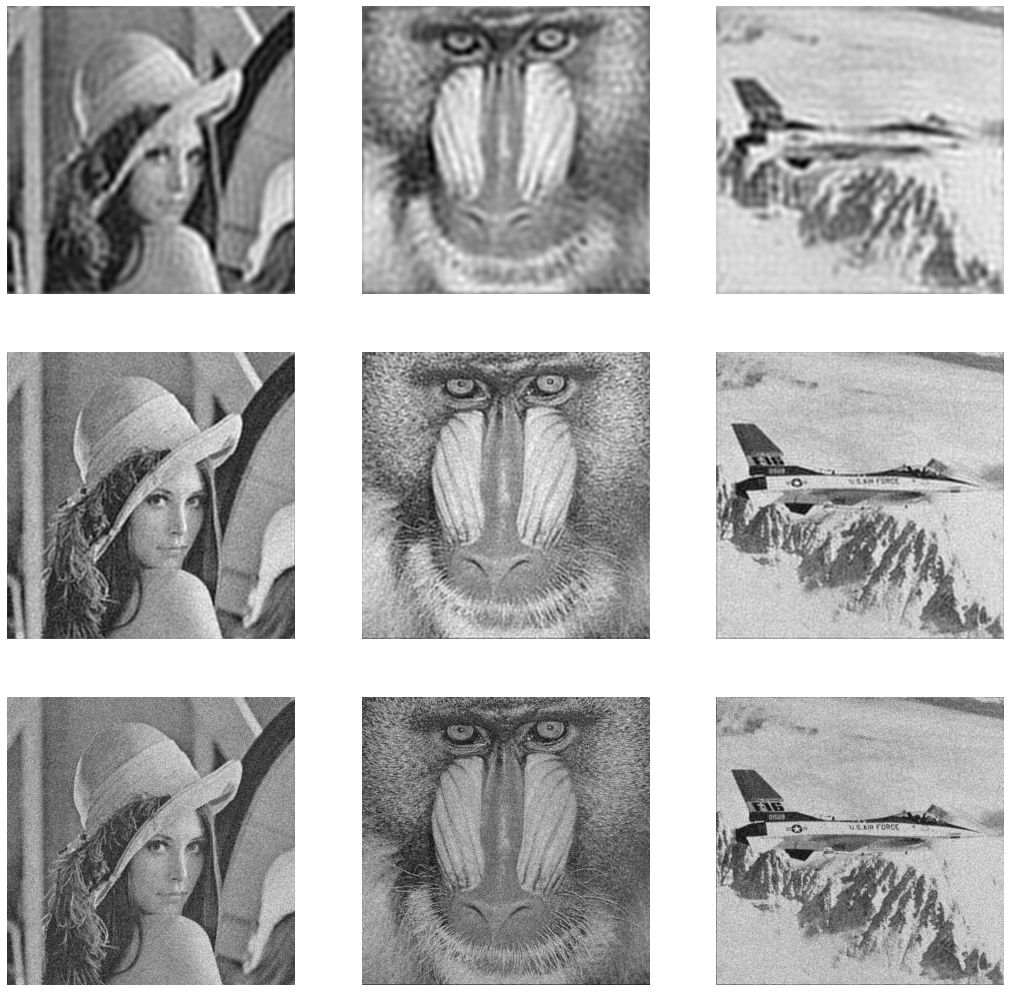

In [13]:
#lena
lena_gaussian_ilp30 = filtering(lena_gaussian_noise.copy().reshape(512, 512), ideal_low_pass_filter(30))
lena_gaussian_ilp80 = filtering(lena_gaussian_noise.copy().reshape(512, 512), ideal_low_pass_filter(80))
lena_gaussian_ilp200 = filtering(lena_gaussian_noise.copy().reshape(512, 512), ideal_low_pass_filter(200))
#Baboon
Baboon_gaussian_ilp30 = filtering(Baboon_gaussian_noise.copy().reshape(512, 512), ideal_low_pass_filter(30))
Baboon_gaussian_ilp80 = filtering(Baboon_gaussian_noise.copy().reshape(512, 512), ideal_low_pass_filter(80))
Baboon_gaussian_ilp200 = filtering(Baboon_gaussian_noise.copy().reshape(512, 512), ideal_low_pass_filter(200))
#F16
F16_gaussian_ilp30 = filtering(F16_gaussian_noise.copy().reshape(512, 512), ideal_low_pass_filter(30))
F16_gaussian_ilp80 = filtering(F16_gaussian_noise.copy().reshape(512, 512), ideal_low_pass_filter(80))
F16_gaussian_ilp200 = filtering(F16_gaussian_noise.copy().reshape(512, 512), ideal_low_pass_filter(200))


images = [lena_gaussian_ilp30, lena_gaussian_ilp80, lena_gaussian_ilp200, 
          Baboon_gaussian_ilp30, Baboon_gaussian_ilp80, Baboon_gaussian_ilp200,
          F16_gaussian_ilp30, F16_gaussian_ilp80, F16_gaussian_ilp200]

fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 18))
for ind, p in enumerate(images):
    ax = axs[ind%3, ind//3]
    ax.imshow(p, cmap = 'gray')
    ax.axis('off')
plt.show()

### uniform noise + ideal low-pass cutoff 30 /  80 /  200

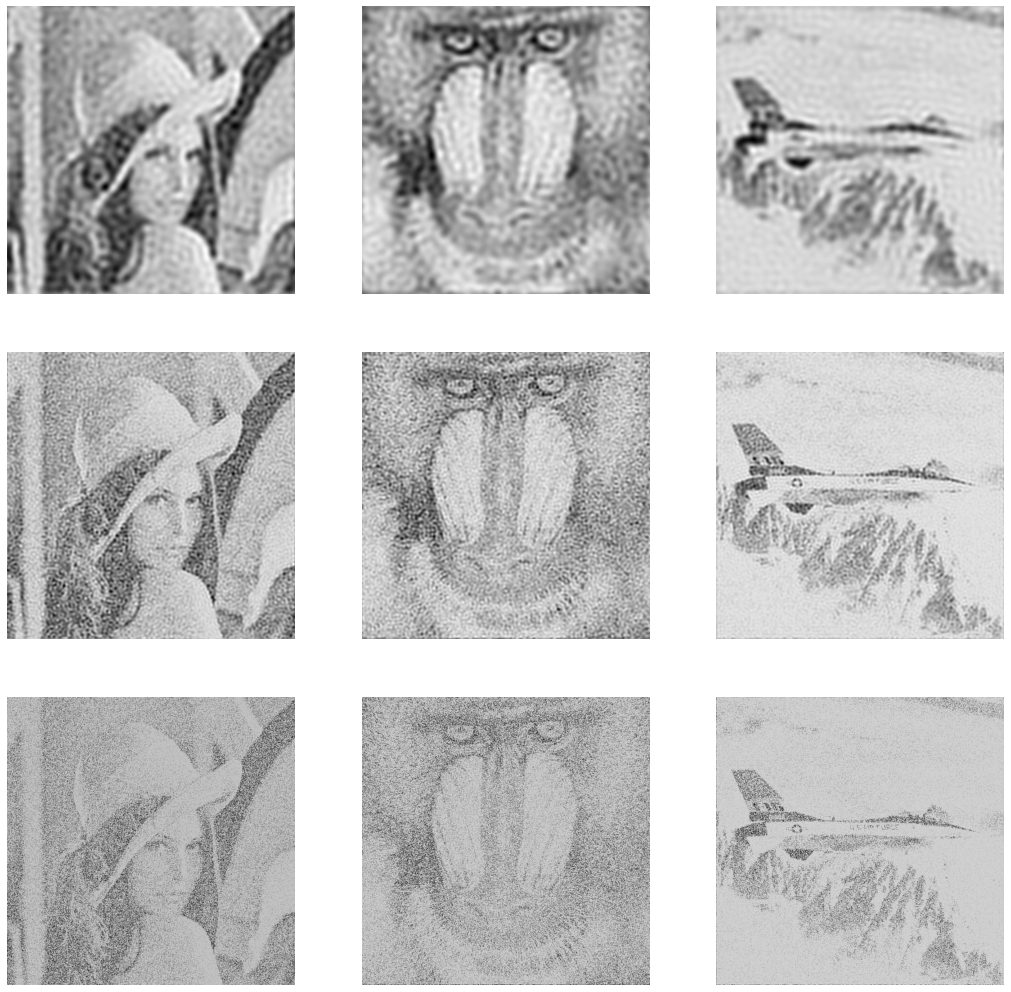

In [14]:
#lena
lena_uniform_ilp30 = filtering(lena_uniform_noise.copy().reshape(512, 512), ideal_low_pass_filter(30))
lena_uniform_ilp80 = filtering(lena_uniform_noise.copy().reshape(512, 512), ideal_low_pass_filter(80))
lena_uniform_ilp200 = filtering(lena_uniform_noise.copy().reshape(512, 512), ideal_low_pass_filter(200))
#Baboon
Baboon_uniform_ilp30 = filtering(Baboon_uniform_noise.copy().reshape(512, 512), ideal_low_pass_filter(30))
Baboon_uniform_ilp80 = filtering(Baboon_uniform_noise.copy().reshape(512, 512), ideal_low_pass_filter(80))
Baboon_uniform_ilp200 = filtering(Baboon_uniform_noise.copy().reshape(512, 512), ideal_low_pass_filter(200))
#F16
F16_uniform_ilp30 = filtering(F16_uniform_noise.copy().reshape(512, 512), ideal_low_pass_filter(30))
F16_uniform_ilp80 = filtering(F16_uniform_noise.copy().reshape(512, 512), ideal_low_pass_filter(80))
F16_uniform_ilp200 = filtering(F16_uniform_noise.copy().reshape(512, 512), ideal_low_pass_filter(200))


images = [lena_uniform_ilp30, lena_uniform_ilp80, lena_uniform_ilp200, 
          Baboon_uniform_ilp30, Baboon_uniform_ilp80, Baboon_uniform_ilp200,
          F16_uniform_ilp30, F16_uniform_ilp80, F16_uniform_ilp200]

fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 18))
for ind, p in enumerate(images):
    ax = axs[ind%3, ind//3]
    ax.imshow(p, cmap = 'gray')
    ax.axis('off')
plt.show()

### iii. Apply the Gaussian low-pass filter to obtain the denoised results with different settings 

In [15]:
def gaussian_low_pass_filter(cutoff):
        """Computes a gaussian low pass mask
        takes as input:
        shape: the shape of the mask to be generated
        cutoff: the cutoff frequency of the gaussian filter (sigma)
        returns a gaussian low pass mask"""
        d0 = cutoff
        rows = 512
        columns = 512
        mask = np.zeros((rows, columns))
        mid_R, mid_C = int(rows / 2), int(columns / 2)
        for i in range(rows):
            for j in range(columns):
                d = math.sqrt((i - mid_R) ** 2 + (j - mid_C) ** 2)
                mask[i, j] = np.exp(-(d * d) / (2 * d0 * d0))

        return mask

### gaussian noise + gaussian low-pass cutoff 30 / 80 / 200

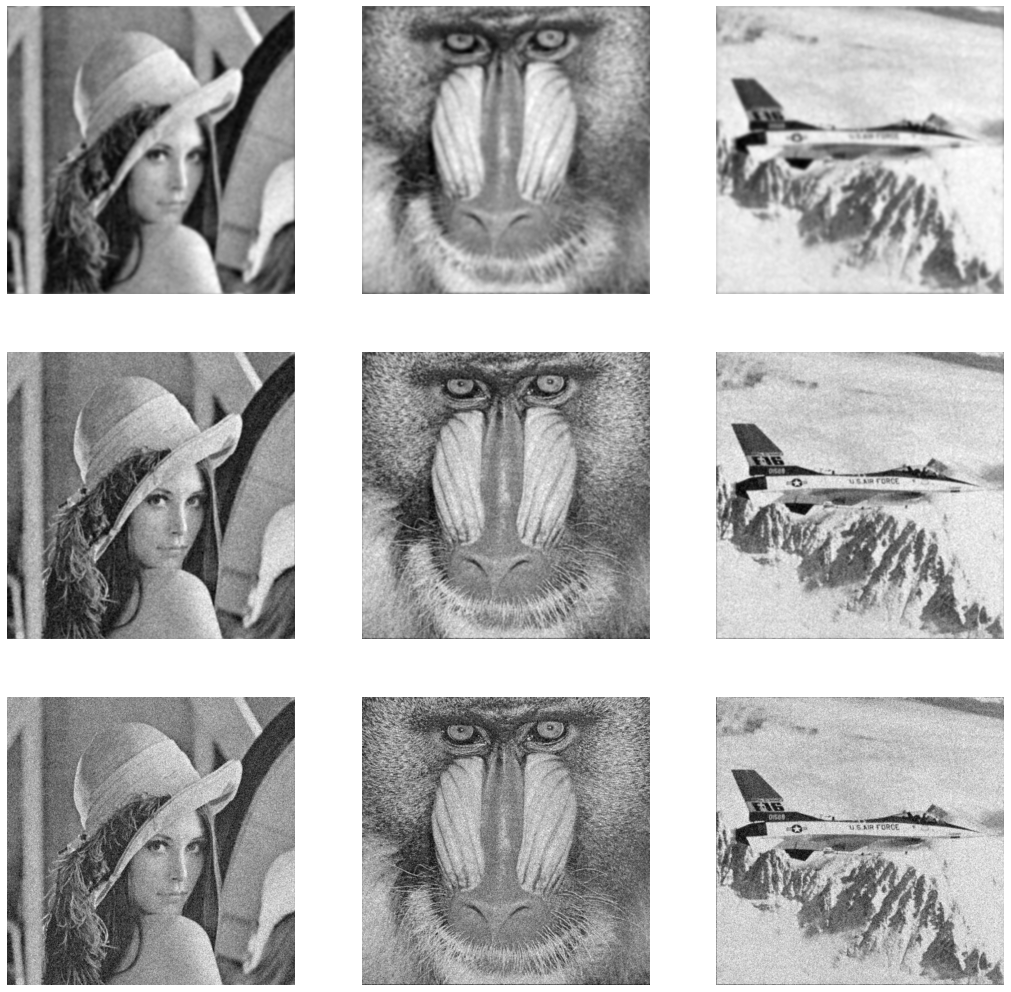

In [16]:
#lena
lena_gaussian_glp30 = filtering(lena_gaussian_noise.copy().reshape(512, 512), gaussian_low_pass_filter(30))
lena_gaussian_glp80 = filtering(lena_gaussian_noise.copy().reshape(512, 512), gaussian_low_pass_filter(80))
lena_gaussian_glp200 = filtering(lena_gaussian_noise.copy().reshape(512, 512), gaussian_low_pass_filter(200))
#Baboon
Baboon_gaussian_glp30 = filtering(Baboon_gaussian_noise.copy().reshape(512, 512), gaussian_low_pass_filter(30))
Baboon_gaussian_glp80 = filtering(Baboon_gaussian_noise.copy().reshape(512, 512), gaussian_low_pass_filter(80))
Baboon_gaussian_glp200 = filtering(Baboon_gaussian_noise.copy().reshape(512, 512), gaussian_low_pass_filter(200))
#F16
F16_gaussian_glp30 = filtering(F16_gaussian_noise.copy().reshape(512, 512), gaussian_low_pass_filter(30))
F16_gaussian_glp80 = filtering(F16_gaussian_noise.copy().reshape(512, 512), gaussian_low_pass_filter(80))
F16_gaussian_glp200 = filtering(F16_gaussian_noise.copy().reshape(512, 512), gaussian_low_pass_filter(200))


images = [lena_gaussian_glp30, lena_gaussian_glp80, lena_gaussian_glp200, 
          Baboon_gaussian_glp30, Baboon_gaussian_glp80, Baboon_gaussian_glp200,
          F16_gaussian_glp30, F16_gaussian_glp80, F16_gaussian_glp200]

fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 18))
for ind, p in enumerate(images):
    ax = axs[ind%3, ind//3]
    ax.imshow(p, cmap = 'gray')
    ax.axis('off')
plt.show()

### uniform noise + gaussian low-pass cutoff 30 / 80 / 200

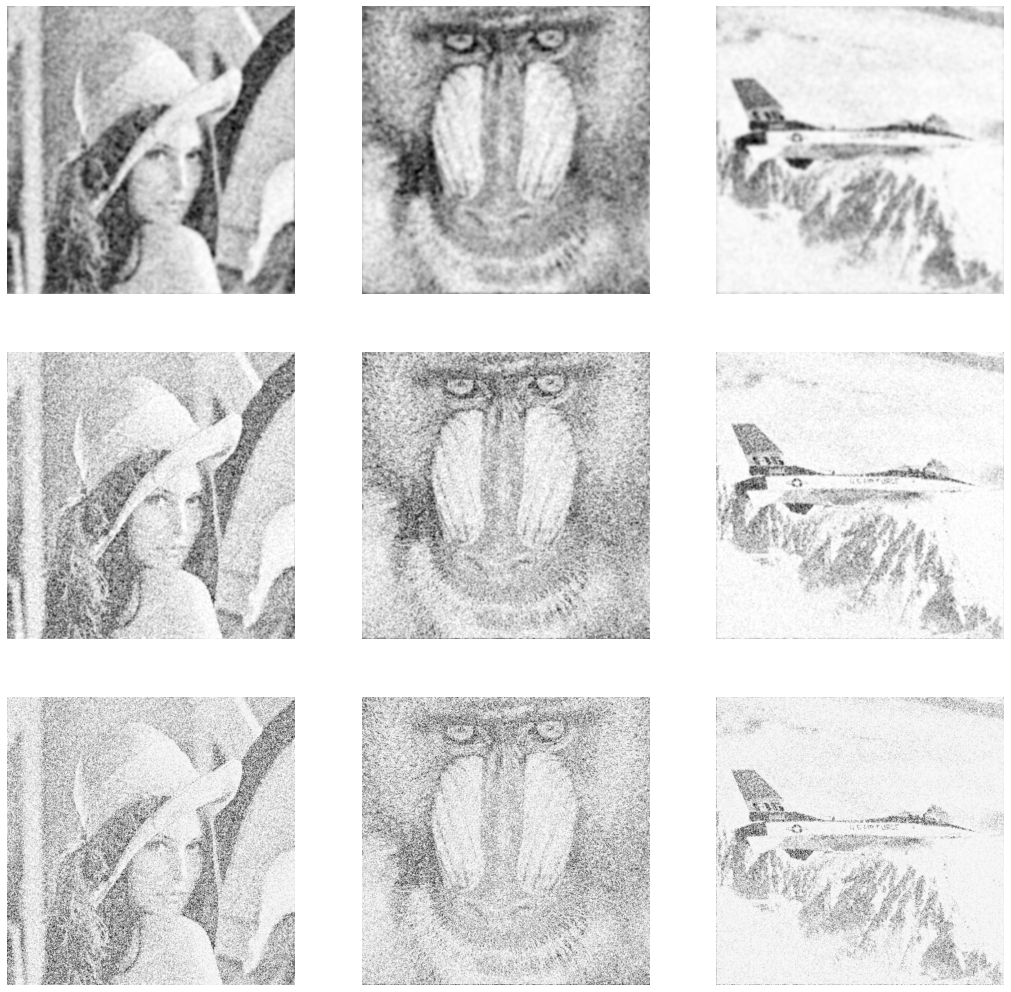

In [17]:
#lena
lena_uniform_glp30 = filtering(lena_uniform_noise.copy().reshape(512, 512), gaussian_low_pass_filter(30))
lena_uniform_glp80 = filtering(lena_uniform_noise.copy().reshape(512, 512), gaussian_low_pass_filter(80))
lena_uniform_glp200 = filtering(lena_uniform_noise.copy().reshape(512, 512), gaussian_low_pass_filter(200))
#Baboon
Baboon_uniform_glp30 = filtering(Baboon_uniform_noise.copy().reshape(512, 512), gaussian_low_pass_filter(30))
Baboon_uniform_glp80 = filtering(Baboon_uniform_noise.copy().reshape(512, 512), gaussian_low_pass_filter(80))
Baboon_uniform_glp200 = filtering(Baboon_uniform_noise.copy().reshape(512, 512), gaussian_low_pass_filter(200))
#F16
F16_uniform_glp30 = filtering(F16_uniform_noise.copy().reshape(512, 512), gaussian_low_pass_filter(30))
F16_uniform_glp80 = filtering(F16_uniform_noise.copy().reshape(512, 512), gaussian_low_pass_filter(80))
F16_uniform_glp200 = filtering(F16_uniform_noise.copy().reshape(512, 512), gaussian_low_pass_filter(200))


images = [lena_uniform_glp30, lena_uniform_glp80, lena_uniform_glp200, 
          Baboon_uniform_glp30, Baboon_uniform_glp80, Baboon_uniform_glp200,
          F16_uniform_glp30, F16_uniform_glp80, F16_uniform_glp200]

fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 18))
for ind, p in enumerate(images):
    ax = axs[ind%3, ind//3]
    ax.imshow(p, cmap = 'gray')
    ax.axis('off')
plt.show()

# 3. High-pass filter

### Use all of the test images as the test samples. Please use the ideal and Butterworth high-pass filters. Make a comparison between the frequency high-pass filter and the Laplacian filter (spatial one).

In [18]:
def ideal_high_pass_filter(cutoff):
        """Computes a Ideal high pass mask
        takes as input:
        shape: the shape of the mask to be generated
        cutoff: the cutoff frequency of the ideal filter
        returns a ideal high pass mask"""

        # Hint: May be one can use the low pass filter function to get a high pass mask
        d0 = cutoff
        # rows, columns = shape
        # mask = np.zeros((rows, columns), dtype=int)
        mask = 1 - ideal_low_pass_filter(d0)
        
        return mask

In [19]:
def butterworth_high_pass_filter(cutoff, order):
        """Computes a butterworth high pass mask
        takes as input:
        shape: the shape of the mask to be generated
        cutoff: the cutoff frequency of the butterworth filter
        order: the order of the butterworth filter
        returns a butterworth high pass mask"""

        d0 = cutoff
        n = order
        rows = 512
        columns = 512
        mask = np.zeros((rows, columns))
        mid_R, mid_C = int(rows / 2), int(columns / 2)
        for i in range(rows):
            for j in range(columns):
                d = math.sqrt((i - mid_R) ** 2 + (j - mid_C) ** 2)
                if d == 0:
                    mask[i, j] = 0
                else:
                    mask[i, j] = 1 / (1 + (d0 / d) ** (2 * n))
        
        return mask

### butterworth_high_pass_filter cutoff 15 / 80 / 200

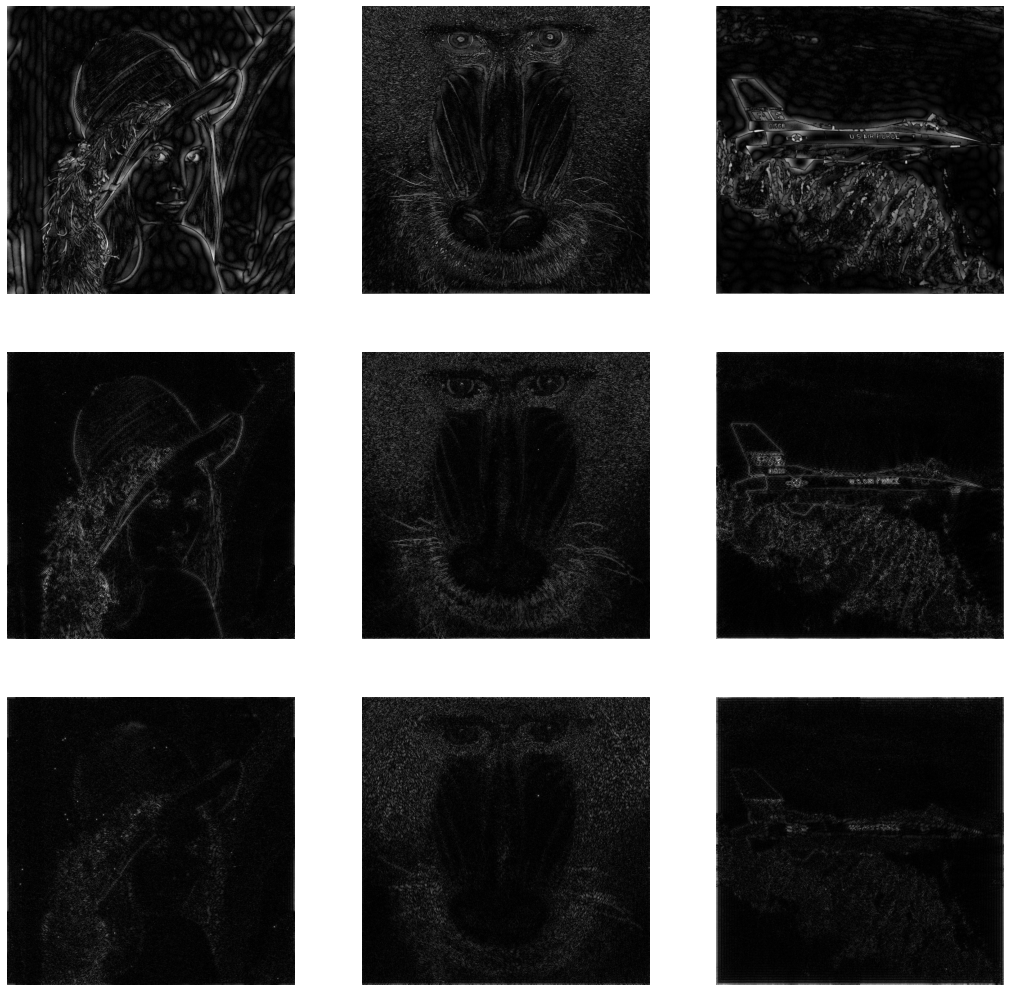

In [20]:
#lena
lena_ihp15 = filtering(img_lena.copy().reshape(512, 512), ideal_high_pass_filter(15))
lena_ihp80 = filtering(img_lena.copy().reshape(512, 512), ideal_high_pass_filter(80))
lena_ihp200 = filtering(img_lena.copy().reshape(512, 512), ideal_high_pass_filter(200))
#Baboon
Baboon_ihp15 = filtering(img_Baboon.copy().reshape(512, 512), ideal_high_pass_filter(15))
Baboon_ihp80 = filtering(img_Baboon.copy().reshape(512, 512), ideal_high_pass_filter(80))
Baboon_ihp200 = filtering(img_Baboon.copy().reshape(512, 512), ideal_high_pass_filter(200))
#F16
F16_ihp15 = filtering(img_F16.copy().reshape(512, 512), ideal_high_pass_filter(15))
F16_ihp80 = filtering(img_F16.copy().reshape(512, 512), ideal_high_pass_filter(80))
F16_ihp200 = filtering(img_F16.copy().reshape(512, 512), ideal_high_pass_filter(200))


images = [lena_ihp15, lena_ihp80, lena_ihp200, 
          Baboon_ihp15, Baboon_ihp80, Baboon_ihp200,
          F16_ihp15, F16_ihp80, F16_ihp200]

fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 18))
for ind, p in enumerate(images):
    ax = axs[ind%3, ind//3]
    ax.imshow(p, cmap = 'gray')
    ax.axis('off')
plt.show()

### butterworth_high_pass_filter cutoff 5 + order 2 / 11/ 20

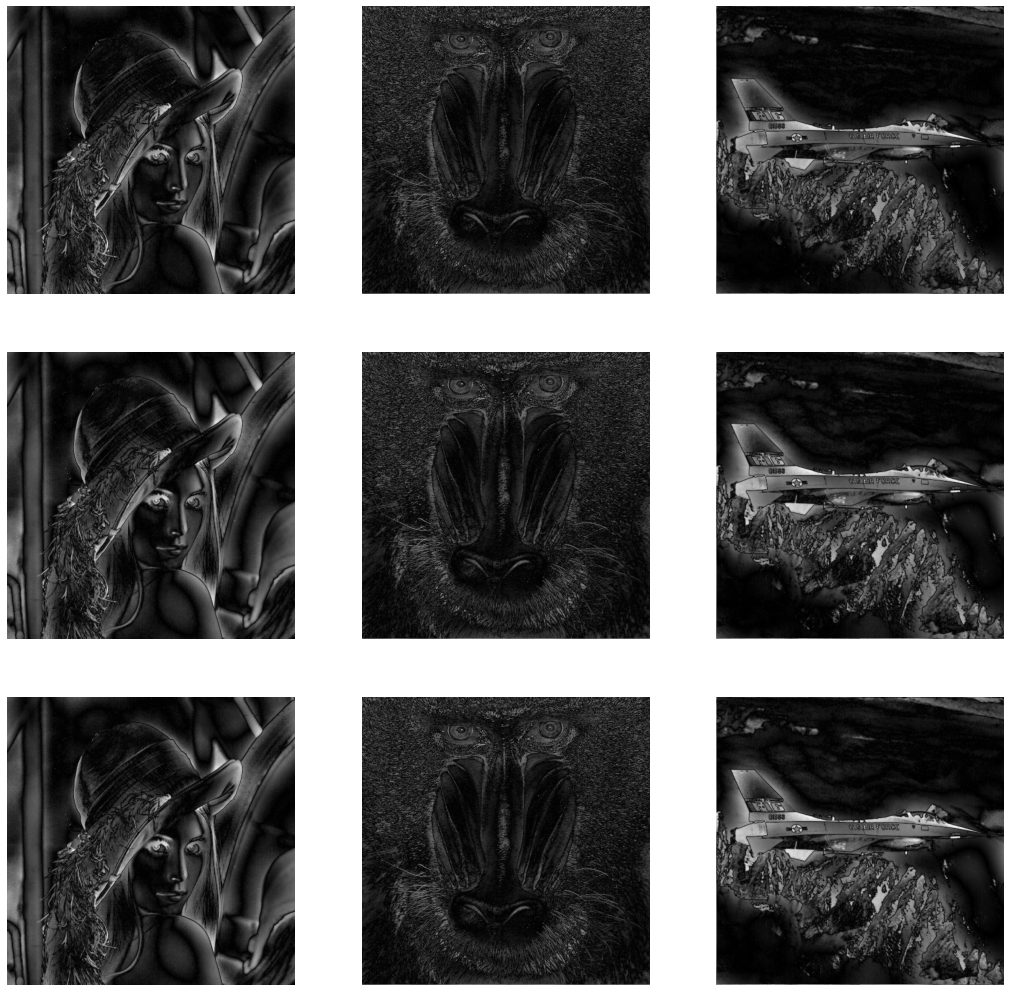

In [21]:
#lena
lena_bhp2 = filtering(img_lena.copy().reshape(512, 512), butterworth_high_pass_filter(5, 2))
lena_bhp11 = filtering(img_lena.copy().reshape(512, 512), butterworth_high_pass_filter(5, 11))
lena_bhp20 = filtering(img_lena.copy().reshape(512, 512), butterworth_high_pass_filter(5, 20))
#Baboon
Baboon_bhp2 = filtering(img_Baboon.copy().reshape(512, 512), butterworth_high_pass_filter(5, 2))
Baboon_bhp11 = filtering(img_Baboon.copy().reshape(512, 512), butterworth_high_pass_filter(5, 11))
Baboon_bhp20 = filtering(img_Baboon.copy().reshape(512, 512), butterworth_high_pass_filter(5, 20))
#F16
F16_bhp2 = filtering(img_F16.copy().reshape(512, 512), butterworth_high_pass_filter(5, 2))
F16_bhp11 = filtering(img_F16.copy().reshape(512, 512), butterworth_high_pass_filter(5, 11))
F16_bhp20 = filtering(img_F16.copy().reshape(512, 512), butterworth_high_pass_filter(5, 100))


images = [lena_bhp2, lena_bhp11, lena_bhp20, 
          Baboon_bhp2, Baboon_bhp11, Baboon_bhp20,
          F16_bhp2, F16_bhp11, F16_bhp20]

fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 18))
for ind, p in enumerate(images):
    ax = axs[ind%3, ind//3]
    ax.imshow(p, cmap = 'gray')
    ax.axis('off')
plt.show()